In [6]:
import numpy as np
import scipy.sparse as sp
import ReservoirComputer3_2 as ReCom
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets
from scipy.interpolate import splprep, splev
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import ReservoirPlot as resplt

## Define functions needed for data generation and simulations:

In [14]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def plot_traj(traj, t_start=0, t_end=15000, xlim=300, ylim=300, zlim=300):
    fig = plt.figure(figsize=(15,9))
    ax = fig.gca(projection="3d")
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)-1):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "b-",
                markersize=2.0, alpha=0.5)
    u = traj[len(traj)-1]
    ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "r-",
            markersize=2.0, alpha=0.5)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                markersize=2.0, alpha=1.0)
    
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)

    
def evolve(RC, ics, t_points):
    ics = ics.copy()
    ics.append(RC.r_T)
    traj = np.zeros((len(ics), len(t_points), RC.d))
    
    for i in range(len(ics)):
        r0 = ics[i]
        PR_traj = integrate.odeint(RC.f_PR, r0, t_points)
        prediction = np.asarray([RC.W_out.dot(RC.q(p)) for p in PR_traj])
        traj[i,:,:] = prediction
    
    return traj 



def nu_epoch_grid_search(RC, train_data, t_points, t_listen, ics, eta_list, epochs_list):
    predictions = np.zeros((nu_list.size ,epochs_list.size + 1 ,len(ics) + 1, t_points.size, RC.d))
    
    for i in range(eta_list.size):
        for j in range(epochs_list.size):
            print(eta_list[i], epochs_list[j])
            RC.eta_i = eta_list[i]
            RC.epochs_i = epochs_list[j]
            RC.IP_train(train_data, t_points_training, t_listen, True)
            training_traj = RC.train(train_data, t_points_training, t_listen)
            pert_traj = evolve(RC, ics, t_points)
            predictions[i, j,:,:,:] = pert_traj

    return predictions

## Generate training and validation data for Lorenz System:

In [8]:
T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

Wall time: 53.6 s


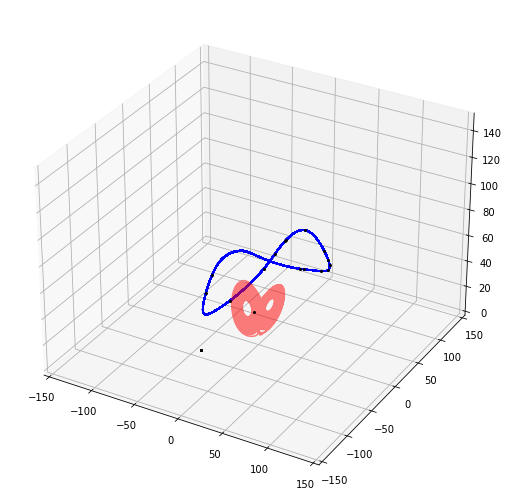

In [11]:
%%time
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=0, epochs_i=0)
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))
trajectories = evolve(RC, ics, t_points_prediction)
plot_traj(trajectories, t_start=1000, t_end=15000, xlim=150, ylim=150, zlim=150)

In [12]:
# Grid search for optimal eta, epoch values
nu_list = np.asarray([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
epochs_list = np.arange(1, 11)

In [15]:
%%time
trajectories = nu_epoch_grid_search(RC, 
                                    train_data, 
                                    t_points_prediction,  
                                    5000,
                                    ics, 
                                    nu_list, 
                                    epochs_list)

1e-09 1
1e-09 2
1e-09 3
1e-09 4
1e-09 5
1e-09 6
1e-09 7
1e-09 8
1e-09 9
1e-09 10
1e-08 1
1e-08 2
1e-08 3
1e-08 4
1e-08 5
1e-08 6
1e-08 7
1e-08 8
1e-08 9
1e-08 10
1e-07 1
1e-07 2
1e-07 3
1e-07 4
1e-07 5
1e-07 6
1e-07 7
1e-07 8
1e-07 9
1e-07 10
1e-06 1
1e-06 2
1e-06 3
1e-06 4
1e-06 5
1e-06 6
1e-06 7
1e-06 8
1e-06 9
1e-06 10
1e-05 1
1e-05 2
1e-05 3
1e-05 4
1e-05 5
1e-05 6
1e-05 7
1e-05 8
1e-05 9
1e-05 10
0.0001 1
0.0001 2
0.0001 3
0.0001 4
0.0001 5
0.0001 6
0.0001 7
0.0001 8
0.0001 9
0.0001 10
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5
0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.01 1


C:\Users\foxda\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
1.0 1
1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
Wall time: 44min 20s


In [16]:
%store trajectories

Stored 'trajectories' (ndarray)


In [17]:
%matplotlib inline
@widgets.interact(i=(0, 9, 1), j=(0, 9, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=150, ylim=150, zlim=150):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(trajectories[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Nu = " + str(nu_list[i]))
    print("Epoch = " + str(epochs_list[j]))

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='j', max=9), …

## Best ($\eta_{i}$ , epoch) values are (1e-5, 5)

In [29]:
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, eta_s=0, epochs_i=5, epochs_s=0)
RC.IP_train(train_data, t_points_training, t_listen=5000)
ip_train_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction_ip = RC.predict(t_points_prediction)

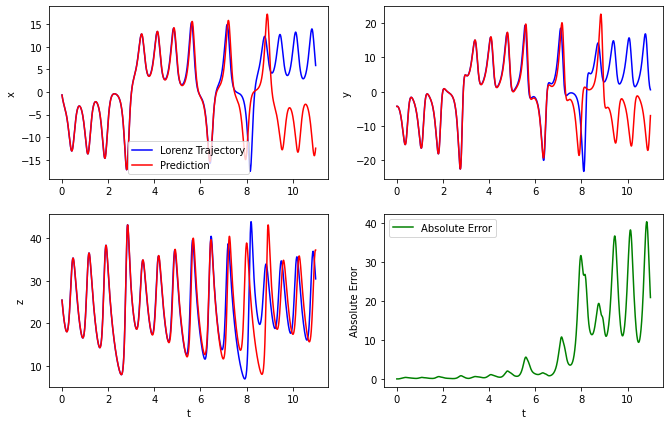

In [30]:
resplt.plot_short_pred(val_data, prediction_ip, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

(array([  4984.,  76077., 204283., 242270., 185044., 191487.,  88553.,
          7302.]),
 array([-0.85208894, -0.64281208, -0.43353521, -0.22425835, -0.01498149,
         0.19429537,  0.40357223,  0.61284909,  0.82212595]),
 <BarContainer object of 8 artists>)

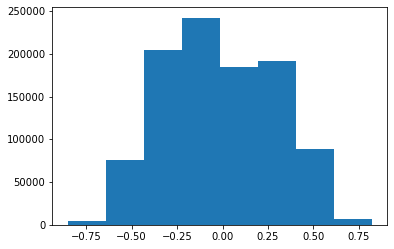

In [24]:
plt.hist(ip_train_traj.flatten(), bins=8)

In [43]:
ip_train_traj[10]

array([ 0.63179062,  0.63215672,  0.62598204, -0.63139821, -0.62959981,
        0.62593005, -0.63213339, -0.63139292,  0.62861646, -0.6321427 ,
        0.62702692, -0.63215734,  0.63212291, -0.63215734,  0.62711981,
        0.63215734, -0.63160779, -0.63215734, -0.63215734,  0.62924137,
       -0.63215734,  0.63215734, -0.63215734, -0.63215734,  0.63215734,
       -0.63215734,  0.63215731, -0.63121605, -0.63215734,  0.63215685,
        0.63215734,  0.63196674, -0.63209962,  0.6321515 ,  0.63152806,
        0.63215734,  0.63164258,  0.61470042, -0.63214421,  0.60874317,
        0.63201512,  0.62937783, -0.62625554, -0.62788341, -0.63215734,
        0.63197359, -0.62917119, -0.63215734, -0.63215734,  0.631713  ,
        0.63215734, -0.63147216, -0.6294491 , -0.62644003, -0.63085091,
       -0.62686975, -0.63215734, -0.63215734,  0.63215578,  0.63212202,
        0.62013524,  0.63215734,  0.63214394,  0.63046831,  0.63215734,
        0.63215734, -0.63215734, -0.63127007, -0.63176866,  0.63